In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import pandas as pd
import numpy as np

# 1. Chargement du fichier compressé (Pandas le gère automatiquement)
# Remplacez par le chemin de votre fichier téléchargé
file_path = 'listings.csv.gz' 
df = pd.read_csv(file_path, compression='gzip')

print(f"Taille brute : {df.shape}")

# 2. Sélection des colonnes utiles (On jette le texte inutile comme les descriptions)
cols_to_keep = [
    'price', 'latitude', 'longitude',           # Le coeur du géospatial
    'accommodates', 'bathrooms_text', 'bedrooms', 'beds', # La taille
    'number_of_reviews', 'review_scores_rating', # La popularité
    'room_type'                                 # Variable catégorielle intéressante
]
df = df[cols_to_keep].copy()

# 3. Nettoyage de la colonne 'price' (Le piège classique)
# Le prix est au format "$1,200.00" (string) -> Il faut le passer en 1200.0 (float)
df['price'] = df['price'].astype(str).str.replace('$', '').str.replace(',', '')
df['price'] = pd.to_numeric(df['price'], errors='coerce')

# 4. Gestion des valeurs manquantes (NaN)
# Pour un projet étudiant, on supprime souvent les lignes vides pour simplifier
df = df.dropna()

# 5. Création de la Cible (Target) pour la LDA
# La LDA a besoin de classes. Créons une classe de prix : "Cher" vs "Pas cher"
# On coupe à la médiane (ex: si la médiane est 150€)
# --- D. Création de la CIBLE (Target) : 4 Classes (Quartiles) ---
# On utilise qcut pour découper en 4 parts égales (0=Eco, 1=Standard, 2=Premium, 3=Luxe)
# Cela remplace la logique binaire précédente.
df['category_price'] = pd.qcut(df['price'], q=4, labels=[0, 1, 2, 3])

print(f"Taille finale nettoyée : {df.shape}")
# On affiche les bornes de prix pour info
print("Bornes des catégories de prix :")
print(pd.qcut(df['price'], q=4).value_counts().sort_index())
print(f"Taille nettoyée : {df.shape}")
print(df.head())

Taille brute : (10480, 79)
Taille finale nettoyée : (5204, 11)
Bornes des catégories de prix :
price
(34.999, 160.0]     1320
(160.0, 220.0]      1288
(220.0, 310.0]      1299
(310.0, 80018.0]    1297
Name: count, dtype: int64
Taille nettoyée : (5204, 11)
   price   latitude  longitude  accommodates bathrooms_text  bedrooms  beds  \
0  132.0  52.387610   4.891880             2      1.5 baths       1.0   1.0   
1   89.0  52.367750   4.890920             2  1 shared bath       1.0   1.0   
2   61.0  52.365840   4.891110             2  1 shared bath       1.0   1.0   
5  322.0  52.380280   4.890890             3         1 bath       2.0   2.0   
6  457.0  52.369378   4.929579             4      1.5 baths       2.0   3.0   

   number_of_reviews  review_scores_rating        room_type category_price  
0                311                  4.92     Private room              0  
1                732                  4.87     Private room              0  
2                849                  

In [3]:
# On garde Lat/Lon + les caractéristiques physiques
X = df[['latitude', 'longitude', 'accommodates', 'bedrooms', 'number_of_reviews', 'review_scores_rating', 'price']]

In [4]:
# Option A : Prédire la gamme de prix (Classification Binaire)
y = df['category_price'] 

# Option B : Prédire le type de logement (Classification Multi-classe)
# C'est plus dur pour la LDA, mais intéressant
y_type = df['room_type']

--- 1. Chargement du fichier local ---
Taille finale nettoyée : (5209, 11)
Prix médian utilisé pour la classe : 220.0 €

--- Exécution PCA ---


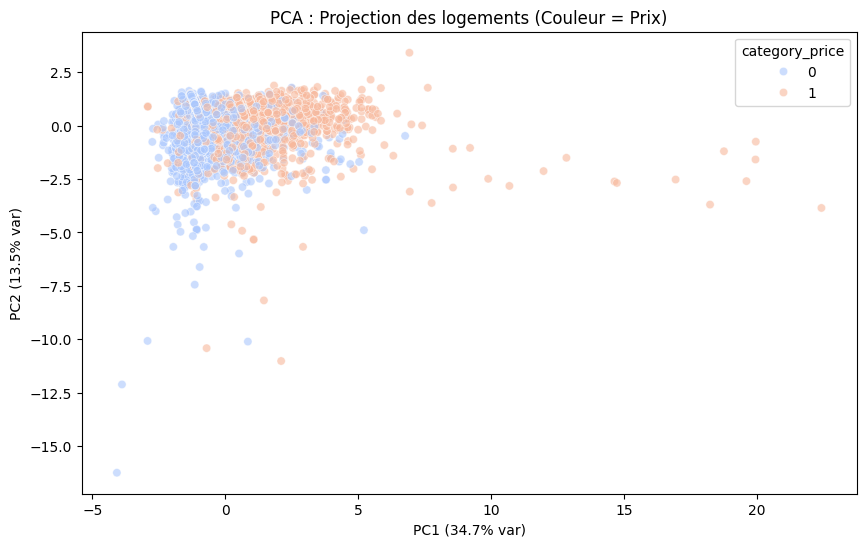

--- Exécution LDA ---
Précision LDA : 73.61%
--- Exécution CART ---
Précision Arbre (CART) : 74.57%


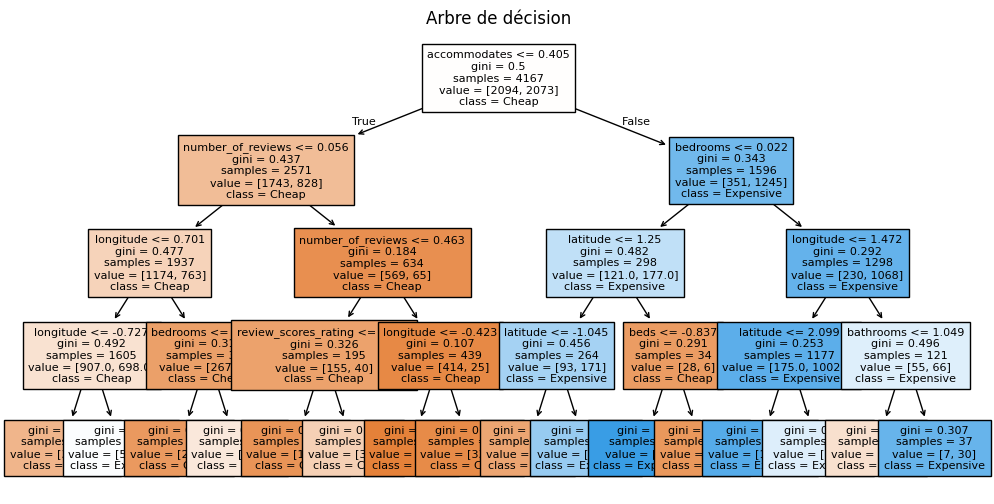

--- Exécution Random Forest ---
Précision Random Forest : 76.58%

Top 3 Variables importantes (RF) :
longitude            0.226742
latitude             0.197663
number_of_reviews    0.168040
dtype: float64

--- Exécution Gradient Boosting ---
Précision Gradient Boosting : 77.64%


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Modules Scikit-Learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score

# ==============================================================================
# 1. CHARGEMENT ET NETTOYAGE (Version Fichier Local)
# ==============================================================================
print("--- 1. Chargement du fichier local ---")

# Chargement depuis le dossier courant
file_path = 'listings.csv.gz' 
try:
    df = pd.read_csv(file_path, compression='gzip')
except FileNotFoundError:
    print(f"ERREUR : Le fichier '{file_path}' est introuvable dans le dossier.")
    print("Vérifiez que le fichier est bien à côté de votre script Python.")
    raise

# Sélection des colonnes utiles
cols_to_keep = [
    'price', 'latitude', 'longitude',           # Le coeur du géospatial
    'accommodates', 'bathrooms_text', 'bedrooms', 'beds', # La taille
    'number_of_reviews', 'review_scores_rating', # La popularité
    'room_type'                                 # Variable catégorielle
]

# On filtre si les colonnes existent (pour éviter les erreurs si le fichier change)
existing_cols = [c for c in cols_to_keep if c in df.columns]
df = df[existing_cols].copy()

# --- A. Nettoyage du PRIX ---
# On enlève le '$' et la ',' puis on convertit en float
df['price'] = df['price'].astype(str).str.replace('$', '', regex=False).str.replace(',', '', regex=False)
df['price'] = pd.to_numeric(df['price'], errors='coerce')

# --- B. Nettoyage des SALLES DE BAIN (CRUCIAL) ---
# Il faut transformer "1.5 baths" (texte) en 1.5 (nombre) pour la PCA/LDA
def extract_bath(text):
    try:
        if pd.isna(text): return 0.0
        # Regex pour trouver un nombre (entier ou décimal)
        match = re.search(r"(\d+(\.\d+)?)", str(text))
        return float(match.group(1)) if match else 0.0
    except:
        return 0.0

if 'bathrooms_text' in df.columns:
    df['bathrooms'] = df['bathrooms_text'].apply(extract_bath)
    df = df.drop(columns=['bathrooms_text']) # On vire la colonne texte
else:
    # Si la colonne n'existe pas (certaines villes), on met 1 par défaut
    df['bathrooms'] = 1.0

# --- C. Suppression des valeurs manquantes ---
df = df.dropna()

# --- D. Création de la CIBLE (Target) ---
# On coupe à la médiane : 0 = Abordable, 1 = Cher
median_price = df['price'].median()
df['category_price'] = (df['price'] > median_price).astype(int) 

print(f"Taille finale nettoyée : {df.shape}")
print(f"Prix médian utilisé pour la classe : {median_price} €")

# ==============================================================================
# 2. PRÉPARATION DES VARIABLES (X et y)
# ==============================================================================
# Liste des variables NUMÉRIQUES pour les algos
feature_names = ['latitude', 'longitude', 'accommodates', 'bedrooms', 
                 'beds', 'bathrooms', 'number_of_reviews', 'review_scores_rating']

# On vérifie qu'elles sont bien toutes là
feature_names = [f for f in feature_names if f in df.columns]

X = df[feature_names]
y = df['category_price']

# Standardisation (Centrer-Réduire) - OBLIGATOIRE pour PCA et LDA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split Train/Test (80% entrainement, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# ==============================================================================
# 3. MÉTHODE 1 : PCA (Analyse en Composantes Principales)
# ==============================================================================
print("\n--- Exécution PCA ---")
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette='coolwarm', alpha=0.6)
plt.title('PCA : Projection des logements (Couleur = Prix)')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} var)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} var)')
plt.show()

# ==============================================================================
# 4. MÉTHODE 2 : LDA (Analyse Discriminante Linéaire)
# ==============================================================================
print("--- Exécution LDA ---")
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
acc_lda = accuracy_score(y_test, lda.predict(X_test))
print(f"Précision LDA : {acc_lda:.2%}")

# ==============================================================================
# 5. MÉTHODE 3 : CART (Arbre de Décision)
# ==============================================================================
print("--- Exécution CART ---")
dt = DecisionTreeClassifier(max_depth=4, random_state=42)
dt.fit(X_train, y_train)
acc_dt = accuracy_score(y_test, dt.predict(X_test))
print(f"Précision Arbre (CART) : {acc_dt:.2%}")

# Affichage de l'arbre
plt.figure(figsize=(12, 6))
plot_tree(dt, feature_names=feature_names, filled=True, class_names=['Cheap', 'Expensive'], fontsize=8)
plt.title("Arbre de décision")
plt.show()

# ==============================================================================
# 6. MÉTHODE 4 : RANDOM FOREST
# ==============================================================================
print("--- Exécution Random Forest ---")
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
acc_rf = accuracy_score(y_test, rf.predict(X_test))
print(f"Précision Random Forest : {acc_rf:.2%}")

# Importance des variables (Pour voir si Lat/Lon comptent)
importances = pd.Series(rf.feature_importances_, index=feature_names).sort_values(ascending=False)
print("\nTop 3 Variables importantes (RF) :")
print(importances.head(3))

# ==============================================================================
# 7. MÉTHODE SUPPLÉMENTAIRE : GRADIENT BOOSTING
# ==============================================================================
print("\n--- Exécution Gradient Boosting ---")
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gb.fit(X_train, y_train)
acc_gb = accuracy_score(y_test, gb.predict(X_test))
print(f"Précision Gradient Boosting : {acc_gb:.2%}")


--- 1. Chargement et Nettoyage ---
Taille finale : (5209, 11)

--- Répartition des classes de prix ---
0: Économique : (34.999, 160.0]
1: Standard : (160.0, 220.0]
2: Premium : (220.0, 310.0]
3: Luxe : (310.0, 80018.0]

--- Exécution PCA ---


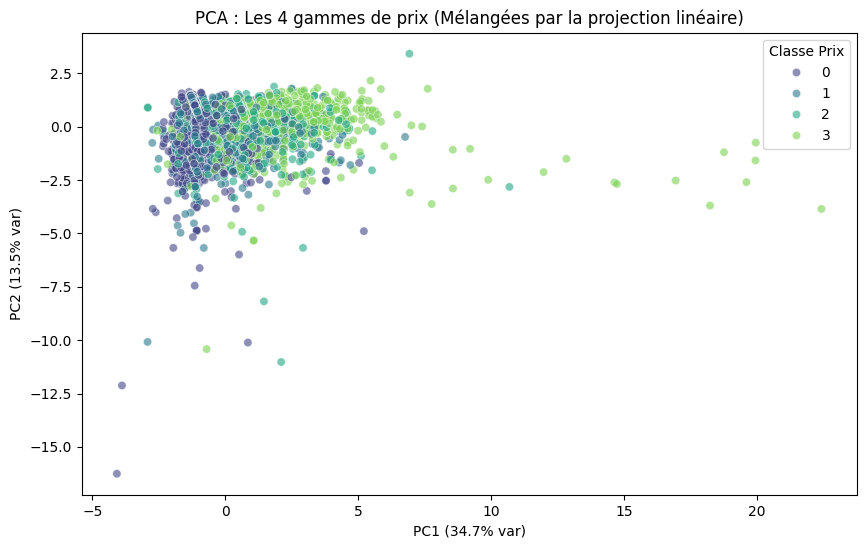

--- Exécution LDA ---
Précision LDA : 48.18%
--- Exécution Random Forest ---
Précision Random Forest : 50.86%

Top 3 Variables les plus importantes :
longitude            0.246223
latitude             0.225956
number_of_reviews    0.184098
dtype: float64
--- Exécution Gradient Boosting ---
Précision Gradient Boosting : 51.34%

--- Exécution t-SNE (Patience...) ---


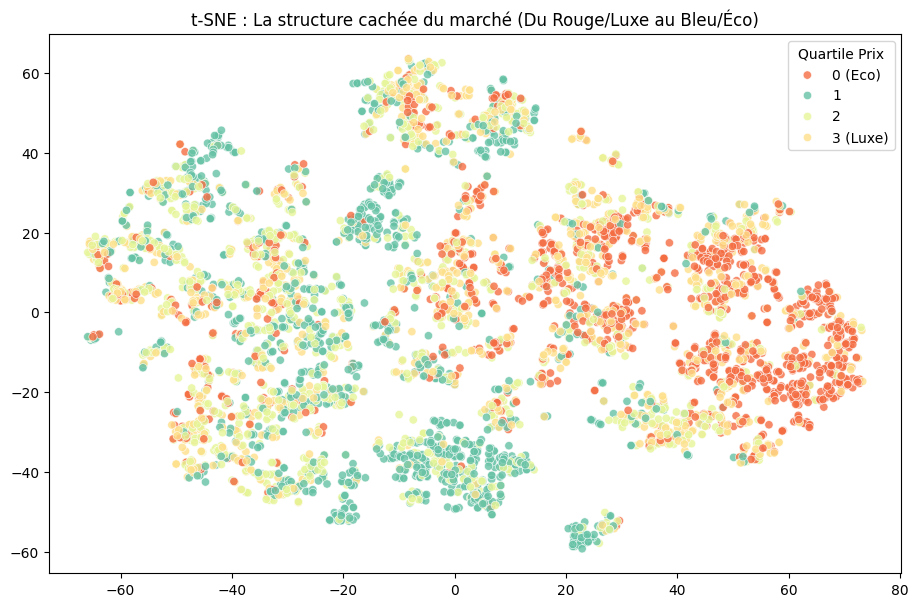


--- TERMINÉ ---


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Modules Scikit-Learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, confusion_matrix

# ==============================================================================
# 1. CHARGEMENT ET NETTOYAGE
# ==============================================================================
print("--- 1. Chargement et Nettoyage ---")

file_path = 'listings.csv.gz' 
try:
    df = pd.read_csv(file_path, compression='gzip')
except FileNotFoundError:
    print(f"ERREUR : Le fichier '{file_path}' est introuvable.")
    raise

# Sélection des colonnes
cols_to_keep = [
    'price', 'latitude', 'longitude',           
    'accommodates', 'bathrooms_text', 'bedrooms', 'beds', 
    'number_of_reviews', 'review_scores_rating', 
    'room_type'                                 
]
# On garde seulement les colonnes qui existent vraiment
existing_cols = [c for c in cols_to_keep if c in df.columns]
df = df[existing_cols].copy()

# A. Nettoyage du PRIX
df['price'] = df['price'].astype(str).str.replace('$', '', regex=False).str.replace(',', '', regex=False)
df['price'] = pd.to_numeric(df['price'], errors='coerce')

# B. Nettoyage des SALLES DE BAIN
def extract_bath(text):
    try:
        if pd.isna(text): return 0.0
        match = re.search(r"(\d+(\.\d+)?)", str(text))
        return float(match.group(1)) if match else 0.0
    except:
        return 0.0

if 'bathrooms_text' in df.columns:
    df['bathrooms'] = df['bathrooms_text'].apply(extract_bath)
    df = df.drop(columns=['bathrooms_text'])
else:
    df['bathrooms'] = 1.0

# C. Suppression des valeurs manquantes
df = df.dropna()

# --- D. CRÉATION DE LA CIBLE (TARGET) : 4 CLASSES ---
# C'est ici que tout change. On divise en 4 groupes égaux (0, 1, 2, 3)
# q=4 signifie "Quartiles" (25% des données dans chaque groupe)
df['category_price'] = pd.qcut(df['price'], q=4, labels=[0, 1, 2, 3])

# On affiche les bornes pour comprendre ce que ça veut dire
print(f"Taille finale : {df.shape}")
print("\n--- Répartition des classes de prix ---")
# On crée un petit tableau pour voir les tranches de prix en Euros
bins = pd.qcut(df['price'], q=4).unique().sort_values()
labels = ["0: Économique", "1: Standard", "2: Premium", "3: Luxe"]
for label, bin_range in zip(labels, bins):
    print(f"{label} : {bin_range}")

# ==============================================================================
# 2. PRÉPARATION (X et y)
# ==============================================================================
feature_names = ['latitude', 'longitude', 'accommodates', 'bedrooms', 
                 'beds', 'bathrooms', 'number_of_reviews', 'review_scores_rating']
feature_names = [f for f in feature_names if f in df.columns]

X = df[feature_names]
y = df['category_price']

# Standardisation (Crucial pour PCA/LDA/t-SNE)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# ==============================================================================
# 3. MÉTHODE 1 : PCA (Visualisation Globale)
# ==============================================================================
print("\n--- Exécution PCA ---")
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
# Palette 'viridis' pour montrer la progression (Bleu -> Jaune)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette='viridis', alpha=0.6)
plt.title('PCA : Les 4 gammes de prix (Mélangées par la projection linéaire)')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} var)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} var)')
plt.legend(title='Classe Prix')
plt.show()

# ==============================================================================
# 4. MÉTHODE 2 : LDA (La méthode linéaire)
# ==============================================================================
print("--- Exécution LDA ---")
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
acc_lda = accuracy_score(y_test, lda.predict(X_test))
print(f"Précision LDA : {acc_lda:.2%}")
# Note : Le score sera bas (~40-50%), c'est normal pour 4 classes !

# ==============================================================================
# 5. MÉTHODES ARBRES (CART & RANDOM FOREST)
# ==============================================================================
print("--- Exécution Random Forest ---")
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
acc_rf = accuracy_score(y_test, rf.predict(X_test))
print(f"Précision Random Forest : {acc_rf:.2%}")

# Importance des variables
importances = pd.Series(rf.feature_importances_, index=feature_names).sort_values(ascending=False)
print("\nTop 3 Variables les plus importantes :")
print(importances.head(3))

# ==============================================================================
# 6. MÉTHODE SUPPLÉMENTAIRE : GRADIENT BOOSTING
# ==============================================================================
print("--- Exécution Gradient Boosting ---")
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gb.fit(X_train, y_train)
acc_gb = accuracy_score(y_test, gb.predict(X_test))
print(f"Précision Gradient Boosting : {acc_gb:.2%}")

# ==============================================================================
# 7. BONUS : t-SNE (Visualisation Topologique)
# ==============================================================================
print("\n--- Exécution t-SNE (Patience...) ---")
# Sous-échantillon pour la vitesse
N_SAMPLES = X_scaled.shape[0]
indices = np.random.choice(X_scaled.shape[0], N_SAMPLES, replace=False)

tsne = TSNE(n_components=2, random_state=42, perplexity=40, init='pca', learning_rate='auto')
X_tsne = tsne.fit_transform(X_scaled[indices])
y_tsne = y.iloc[indices]

plt.figure(figsize=(11, 7))
# On utilise une palette divergente (Spectral) pour bien voir les extrêmes
scatter = sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y_tsne, palette='Spectral_r', alpha=0.8)
plt.title('t-SNE : La structure cachée du marché (Du Rouge/Luxe au Bleu/Éco)')
plt.legend(title='Quartile Prix', labels=['0 (Eco)', '1', '2', '3 (Luxe)'])
plt.show()

print("\n--- TERMINÉ ---")

c:\Users\User\M1ES\ML_ProjectM1\envproject\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



--- Exécution UMAP (Souvent plus rapide que t-SNE) ---


c:\Users\User\M1ES\ML_ProjectM1\envproject\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP terminé en 25.18 secondes.


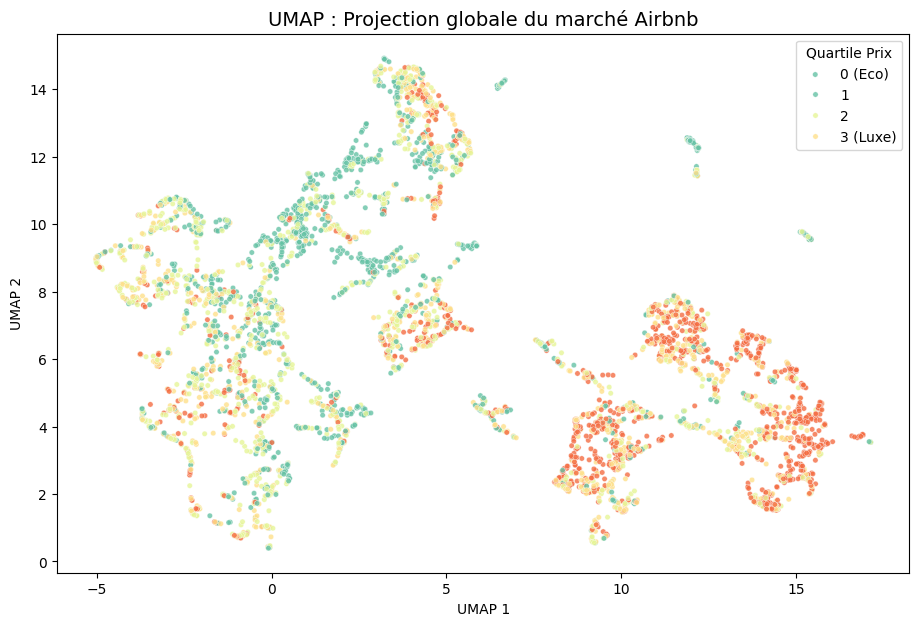

In [7]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns
import time

print("\n--- Exécution UMAP (Souvent plus rapide que t-SNE) ---")

# 1. Configuration et Entraînement
# n_neighbors : La taille du "voisinage". 
#   - Petit (5-10) = Focus sur le détail local. 
#   - Grand (20-50) = Focus sur la structure globale (la carte de la ville).
start_time = time.time()
reducer = umap.UMAP(n_neighbors=10, min_dist=0.1, random_state=42)
X_umap = reducer.fit_transform(X_scaled)
end_time = time.time()

print(f"UMAP terminé en {end_time - start_time:.2f} secondes.")

# 2. Visualisation
plt.figure(figsize=(11, 7))
sns.scatterplot(
    x=X_umap[:, 0], 
    y=X_umap[:, 1], 
    hue=y, 
    palette='Spectral_r', 
    alpha=0.8,
    s=15 # Taille des points
)
plt.title('UMAP : Projection globale du marché Airbnb', fontsize=14)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend(title='Quartile Prix', labels=['0 (Eco)', '1', '2', '3 (Luxe)'])
plt.show()


--- Génération du Comparatif ULTIME : Réalité vs t-SNE vs UMAP ---


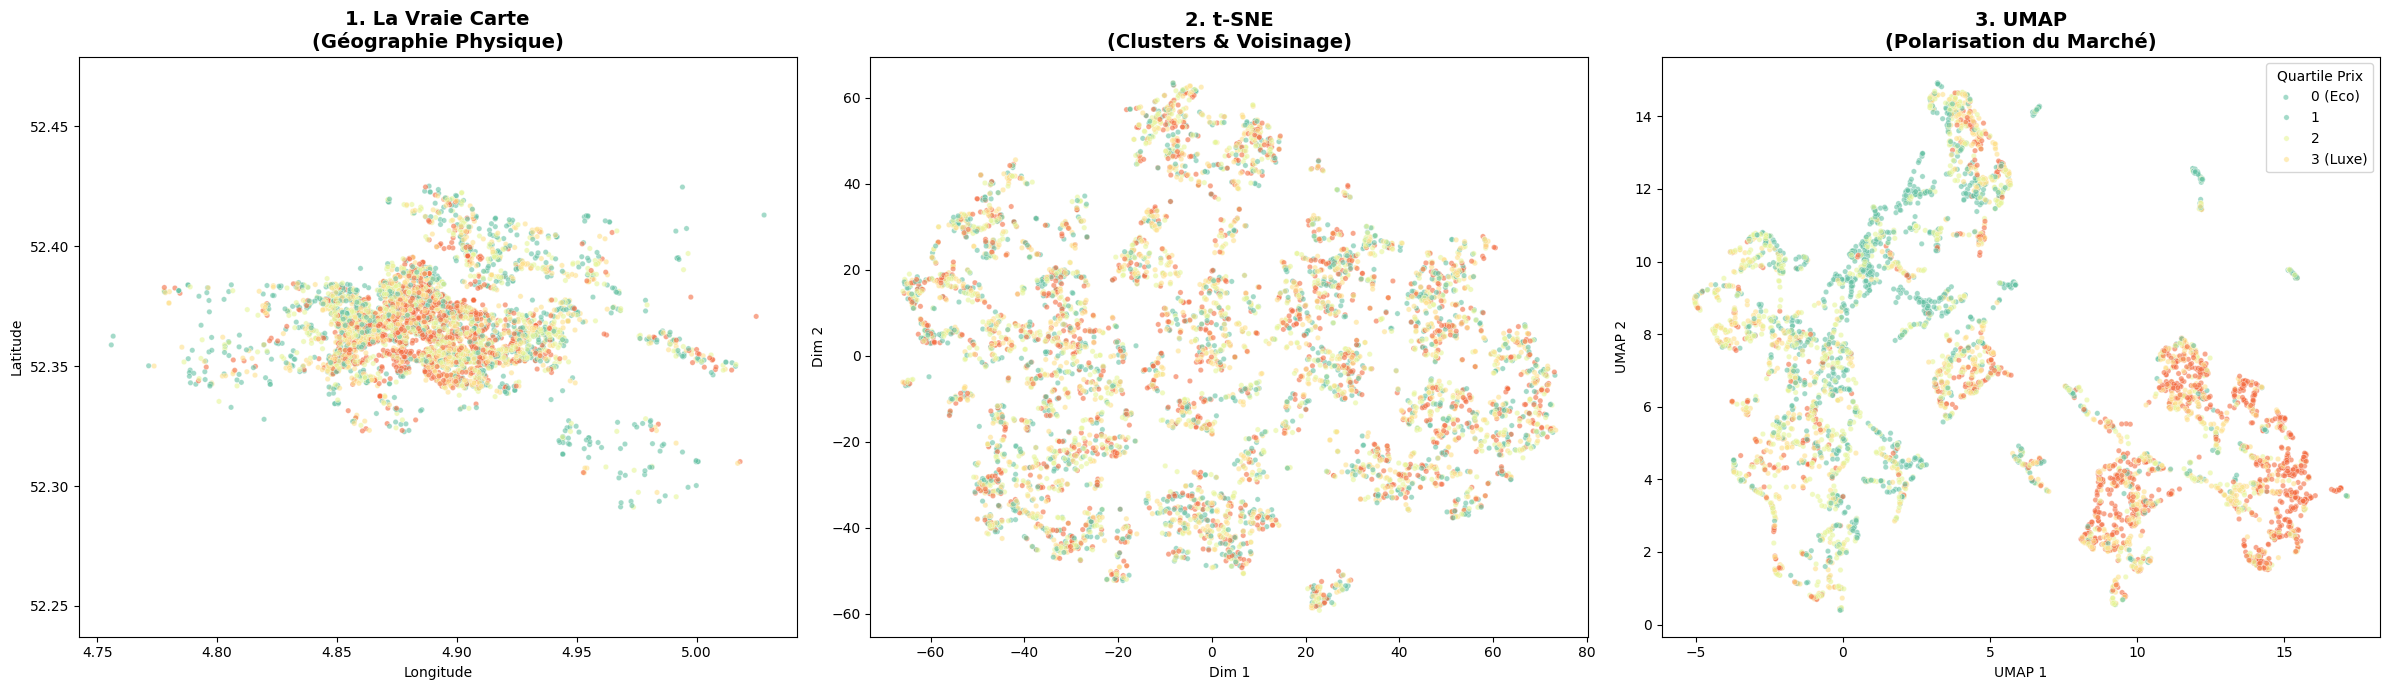

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

print("\n--- Génération du Comparatif ULTIME : Réalité vs t-SNE vs UMAP ---")

# ÉTAPE PRÉALABLE : S'assurer que t-SNE est calculé sur TOUT le dataset (comme la carte et UMAP)
# Si X_tsne n'existe pas ou n'a pas la même taille que df, on le recalcule vite fait.
if 'X_tsne' not in locals() or X_tsne.shape[0] != df.shape[0]:
    print("Calcul du t-SNE sur l'ensemble des données pour alignement... (Patientez)")
    # On réduit la perplexité pour aller plus vite sur 5000 points
    tsne_full = TSNE(n_components=2, random_state=42, perplexity=40, init='pca', learning_rate='auto')
    X_tsne = tsne_full.fit_transform(X_scaled)

# On crée une figure large avec 3 colonnes
fig, axes = plt.subplots(1, 3, figsize=(24, 7))

# --- GRAPHIQUE 1 : LA VRAIE CARTE (Réalité Physique) ---
sns.scatterplot(
    data=df, 
    x='longitude', 
    y='latitude', 
    hue='category_price', 
    palette='Spectral_r', 
    alpha=0.6, 
    s=15, 
    ax=axes[0],
    legend=False
)
axes[0].set_title("1. La Vraie Carte\n(Géographie Physique)", fontsize=14, fontweight='bold')
axes[0].set_xlabel("Longitude")
axes[0].set_ylabel("Latitude")
axes[0].axis('equal') # Indispensable pour ne pas déformer Amsterdam

# --- GRAPHIQUE 2 : t-SNE (Clusters Locaux) ---
sns.scatterplot(
    x=X_tsne[:, 0], 
    y=X_tsne[:, 1], 
    hue=y, 
    palette='Spectral_r', 
    alpha=0.6, 
    s=15, 
    ax=axes[1],
    legend=False
)
axes[1].set_title("2. t-SNE\n(Clusters & Voisinage)", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Dim 1")
axes[1].set_ylabel("Dim 2")

# --- GRAPHIQUE 3 : UMAP (Structure Globale) ---
sns.scatterplot(
    x=X_umap[:, 0], 
    y=X_umap[:, 1], 
    hue=y, 
    palette='Spectral_r', 
    alpha=0.6, 
    s=15, 
    ax=axes[2]
)
axes[2].set_title("3. UMAP\n(Polarisation du Marché)", fontsize=14, fontweight='bold')
axes[2].set_xlabel("UMAP 1")
axes[2].set_ylabel("UMAP 2")
# Légende uniquement sur le dernier pour ne pas charger
axes[2].legend(title='Quartile Prix', labels=['0 (Eco)', '1', '2', '3 (Luxe)'], loc='best')

plt.tight_layout()
plt.show()